In [9]:
from typing import List, Tuple, Union
import numpy as np
import torch
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from dataset import *
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn.functional as F
import numpy as np

In [2]:
import numpy as np
from IPython.display import clear_output

train_names = ['TS_5_4', 'TS_6_4','TS_69_2', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
valid_dir = '../input/czii-cryo-et-object-identification/train'



for name in train_names:
    mask_list = read_one_truth(name, f'{valid_dir}/overlay/ExperimentRuns')

    all_mask = np.zeros((7, 184, 630, 630))
    all_mask[0, :, :, :] = np.ones((184, 630, 630))
    for mol in range(len(PARTICLE)):
        canvas = np.zeros((184, 630, 630))  # z, y, x の順

        mol_name = PARTICLE[mol]["name"]
        mol_size = PARTICLE[mol]["radius"]/10

        n = len(mask_list[mol_name])
        print(n)

        # 全座標グリッドを一括生成（z, y, x の形状に注意）
        z_grid = np.arange(184)
        y_grid = np.arange(630)
        x_grid = np.arange(630)
        zz, yy, xx = np.meshgrid(z_grid, y_grid, x_grid, indexing='ij')  # (32, 630, 630)

        for i in range(n):
            #デバック用に5以上の場合はbreak
            #if i > 5:
            #   break
            clear_output(wait=True)
            print(i)
            # 各中心点をスケーリング
            x, y, z = mask_list[mol_name][i]
            point_x = x * 0.1
            point_y = y * 0.1
            point_z = z * 0.1
            print(point_x, point_y, point_z)

            # 各中心点からの距離の平方を一括計算
            distance_squared = ((xx - point_x) ** 2 + 
                                (yy - point_y) ** 2 + 
                                (zz - point_z) ** 2)

            # ガウス分布値を計算してキャンバスに加算
            canvas += np.exp(-distance_squared / (2 * mol_size ** 2))
            all_mask[0, :, :, :] -= np.exp(-distance_squared / (2 * mol_size ** 2))
        all_mask[mol + 1, :, :, :] = canvas
    all_mask = np.clip(all_mask, 0, 1)
    all_mask = all_mask.astype(np.float32)
    np.savez_compressed(f'../input/mask/generated{name}_mask', all_mask)


12
569.8538 333.14270000000005 80.6002


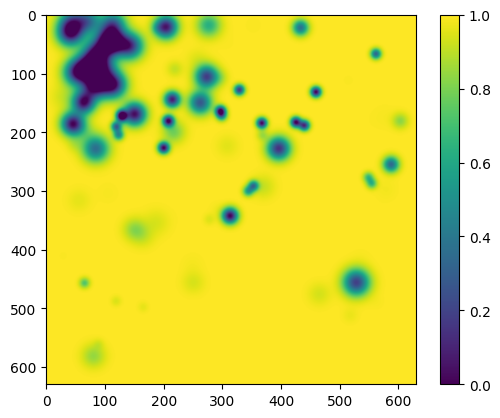

In [4]:
#canvasの可視化
plt.imshow(all_mask[0][32])
plt.colorbar()
plt.show()

In [12]:
all_mask.shape
#tensorに変換
mask = torch.tensor(all_mask)
#バッチサイズ1の次元を追加
mask = mask.unsqueeze(0)
mask.shape

torch.Size([1, 7, 184, 630, 630])

In [8]:
logit = torch.rand((1, 7,184, 640, 640), dtype=torch.float32)
logit.shape

torch.Size([1, 7, 184, 640, 640])